In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [39]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from tensorflow.keras import Input, Model, models, optimizers
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU, concatenate, Flatten, Embedding
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import string

ROOT_PATH = '/content/gdrive/MyDrive/PandemicDataHack/'

In [12]:
# Блок хранения функций


# Чтение данных из словаря
def read_dictionary(pathCSV, columnName, suffix):
    df = pd.read_csv(pathCSV)
    #Кодируем категориальную переменную
    regionEncoder = LabelEncoder()
    regionVec = regionEncoder.fit_transform(df.loc[:, columnName])
    regionNumClasses = len(regionEncoder.classes_)
    #Добавляем коды
    for i in range(len(df)):
        df.loc[i, 'code'] = regionVec[i]
    #Строим названия новых столбцов
    columns = []
    for i in range(regionNumClasses):
        columns.append(suffix + str(i))
    #Проводим преобразование кодов к формату one hot encoding
    newData = []
    for i in range(len(df)):
        oneHot=np_utils.to_categorical(df.loc[i, 'code'],
                                       num_classes=regionNumClasses)
        newData.append(oneHot)
    df2 = pd.DataFrame(data=newData, columns=columns)
    for col in columns:
        df2[col] = df2[col].astype('int8')
    #Объединяем датафреймы
    del(df['code'])
    df = pd.concat([df, df2], axis=1)
    return df


# Преобразование категорий водительских прав
def convert_drive_licences(licence):
    columns = ['catA', 'catB', 'catC', 'catD', 'catE']
    newData = []
    for i in range(len(licence)):
        newData.append([0, 0, 0, 0, 0])
        if str(licence[i]).find('A') > 0:
            newData[i][0] = 1
        if str(licence[i]).find('B') > 0:
            newData[i][1] = 1
        if str(licence[i]).find('C') > 0:
            newData[i][2] = 1
        if str(licence[i]).find('D') > 0:
            newData[i][3] = 1
        if str(licence[i]).find('E') > 0:
            newData[i][4] = 1
    result = pd.DataFrame(data=newData, columns=columns)
    for col in columns:
        result[col] = result[col].astype('int8')
    return result


# Преобразование графика работы
def convert_shedule(df, catName, colName):
    newData = []
    row = []
    for i in range(len(df['schedule'])):
        row = []
        for j in range(len(catName)):
            if df.loc[i, 'schedule'].find(catName[j]) > -1:
                row.append(1)
            else:
                row.append(0)
        newData.append(row)
    result = pd.DataFrame(data=newData, columns=colName)
    return result


# Чтение простого словаря (один столбец без заголовка)
def read_simple_dictionary(path):
    result = []
    fileDict = open(path, 'r')
    for row in fileDict:
        result.append(row)
    fileDict.close()
    return result


# Создание словаря с частотным кодированием категориальных данных
def create_dictionary(df, colName):
    fe = df.groupby(colName).size() / len(df)
    listTemp = []
    dfTemp = df[colName]
    dfTemp = dfTemp.dropna()
    listTemp = dfTemp.unique()
    listTemp.sort()
    fileDict = open(ROOT_PATH + 'dict_' + colName + '.csv', 'w')
    fileDict.write(colName + ';' + colName + '_fe\n')
    for i in range(len(listTemp)):
        fileDict.write(listTemp[i] + ';' + str(fe[i]) + '\n')
    fileDict.close()


# Преобразование данных к виду для нейронки
def convert_for_neural_network(df):
    # Преобразование данных о графике работы
    catSchedule = read_simple_dictionary(ROOT_PATH + 'dict_schedule.csv')
    columns = []
    for i in range(len(catSchedule)):
        columns.append('schedule' + str(i))
    dfTemp = convert_shedule(df, catSchedule, columns)
    df = pd.concat([df, dfTemp], axis=1)
    # Преобразование категории водительских прав
    dfTemp = convert_drive_licences(df['drive_licences'])
    df = pd.concat([df, dfTemp], axis=1)
    # Чтение частотных характеристик категориальных данных из словарей,
    # добавление колонок к основному датасету
    dfTemp = pd.read_csv(ROOT_PATH + 'dict_region.csv', sep=';')
    df = df.merge(dfTemp)
    dfTemp = pd.read_csv(ROOT_PATH + 'dict_industry.csv', sep=';')
    df = df.merge(dfTemp)
    dfTemp = pd.read_csv(ROOT_PATH + 'dict_education_type.csv', sep=';')
    df = df.merge(dfTemp)
    dfTemp = pd.read_csv(ROOT_PATH + 'dict_citizenship.csv', sep=';')
    df = df.merge(dfTemp)
    dfTemp = pd.read_csv(ROOT_PATH + 'dict_employement_type.csv', sep=';')
    df = df.merge(dfTemp)
    # Удаление преобразованных колонок
    df.drop(['region', 'industry', 'education_type', 'citizenship',
             'employement_type', 'schedule', 'drive_licences'], axis='columns',
            inplace=True)
    # Удаление не используемых (пока) в модели колонок
    df.drop(['locality', 'locality_name', 'is_worldskills_participant',
             'completeness_rate', 'creation_date', 'modification_date', 
             'publish_date'], axis='columns', inplace=True)
    return df


# Чистка данных, заполнение пустот
def clean_and_fill_data(df):
    df['relocation_ready'] = df['relocation_ready'].fillna(False).astype('int8')
    df['travel_ready'] = df['travel_ready'].fillna(False).astype('int8')
    df['retraining_ready'] = df['retraining_ready'].fillna(False).astype('int8')

    df['has_qualifications'] = df['has_qualifications'].fillna(0)
    df['has_qualifications'] = df['has_qualifications'].replace('Свидетельство о независимой оценке квалификации', 1)
    df['has_qualifications'] = df['has_qualifications'].astype('int8')

    df['gender'] = df['gender'].replace('Мужской', 1)
    df['gender'] = df['gender'].replace('Женский', 0)
    df['gender'] = df['gender'].fillna(0)
    df['gender'] = df['gender'].astype('int8')

    # Пока заменяю регион на Москву, нужно будет сделать определение региона
    # по locality
    df['region'] = df['region'].fillna('г. Москва')

    # Пока заменяю образование на среднее (все окончили школу), нужно будет
    # вытаскивать его из документа об образовании
    df['education_type'] = df['education_type'].fillna('Среднее')

    # Возраст заменяю на медиану для пропусков и выбросов за границы 18-65
    ageMedian = df['age'].median()
    df['age'] = df['age'].fillna(2000)
    for i in range(len(df['age'])):
        if not (17 < df.loc[i, 'age'] < 60):
            #print('!')
            if 0 <= df.loc[i, 'experience'] <= 50:
                df.loc[i, 'age'] = 18 + df.loc[i, 'experience']
            else:
                df.loc[i, 'age'] = ageMedian
    # В опыте заменяю на медиану значения превышающие 50 лет
    experienceMedian = df['experience'].median()
    df['experience'] = np.where(df['experience'] > 50, experienceMedian,
                                df['experience'])
    # Обработка выбросов по желаемой зарплате
    # TODO: нам по идее для каждой специальности и региона надо отдельный
    # потолок зарплаты
    df['salary_desired'] = np.where(df['salary_desired'] < 0,
                                    -1 * df['salary_desired'],
                                    df['salary_desired'])
    # Чистка поля профессия (преобразование в нижний регистр, удаление знаков
    # преgинания) by Иван
    df['position'] = df['position'].str.lower()
    df['position'] = df['position'].str.translate(str.maketrans
                                                  ('', '', string.punctuation))
    return df

In [13]:
df = pd.read_csv(ROOT_PATH + 'train.csv', sep=';')
# Удаляем выбросы по зарплате - находим границы нормального распределения
q1 = df['salary'].quantile(0.25)
q3 = df['salary'].quantile(0.75)
maxSalary = int(q3 + 1.5 * (q3 - q1))
print(maxSalary)
# Значение maxSalary округляем до 90 000. Все, что больше можно выкинуть
print(df.shape)
df = df[df['salary'] <= 90000].reset_index(drop=True)
df.info()

86315
(306270, 25)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285519 entries, 0 to 285518
Data columns (total 25 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          285519 non-null  int64  
 1   position                    285519 non-null  object 
 2   region                      285510 non-null  object 
 3   industry                    285519 non-null  object 
 4   locality                    285519 non-null  int64  
 5   locality_name               271637 non-null  object 
 6   education_type              247081 non-null  object 
 7   drive_licences              108360 non-null  object 
 8   citizenship                 285519 non-null  object 
 9   schedule                    285519 non-null  object 
 10  employement_type            285519 non-null  object 
 11  age                         278464 non-null  float64
 12  gender                      278492 non-null  object 


In [14]:
df = clean_and_fill_data(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285519 entries, 0 to 285518
Data columns (total 25 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          285519 non-null  int64  
 1   position                    285519 non-null  object 
 2   region                      285519 non-null  object 
 3   industry                    285519 non-null  object 
 4   locality                    285519 non-null  int64  
 5   locality_name               271637 non-null  object 
 6   education_type              285519 non-null  object 
 7   drive_licences              108360 non-null  object 
 8   citizenship                 285519 non-null  object 
 9   schedule                    285519 non-null  object 
 10  employement_type            285519 non-null  object 
 11  age                         285519 non-null  float64
 12  gender                      285519 non-null  int8   
 13  experience    

In [33]:
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Tokenizer
#create filters
to_exclude = '".,:!?#$%&()*+-/<=>@[\\]^_`{|}~\t\n'#excluded symbols
to_tokenize = '.,:!?"'#processed symbols

#create subframes
dfPosition = df['position']
num_words = 20000 #max number words in dictonary
max_review_len = 100 #max len of text
tokenizer_position = Tokenizer(num_words=num_words, filters=to_exclude, oov_token=1)
tokenizer_position.fit_on_texts(dfPosition)

tokenizer_position.word_index
#print(tokenizer_position.num_words)

# Обработка по полученному словарю
sequences_position = tokenizer_position.texts_to_sequences(dfPosition)
max_position_len=10
sequences_position_padded = pad_sequences(sequences_position, maxlen=max_position_len)
print(sequences_position_padded[0])
print(type(sequences_position_padded))
print(type(sequences_position_padded[0]))
print(type(sequences_position_padded[0][0]))

[0 0 0 0 0 0 0 0 0 2]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.int32'>


In [34]:
# Производим частотное кодирование категориальных данных - создаем словари
create_dictionary(df, 'region')
create_dictionary(df, 'industry')
create_dictionary(df, 'education_type')
create_dictionary(df, 'citizenship')
create_dictionary(df, 'employement_type')

# Создание словаря с категориями графика работы
dfTemp = df['schedule'].unique()
catSchedule = []
for i in range(len(dfTemp)):
    if dfTemp[i].find(',') == -1:
        catSchedule.append(dfTemp[i])
fileDict = open(ROOT_PATH + 'dict_schedule.csv', 'w')
for i in range(len(catSchedule)):
    fileDict.write(catSchedule[i] + '\n')
fileDict.close()

df = convert_for_neural_network(df)
display(df.head())

,id,position,age,gender,experience,salary_desired,relocation_ready,travel_ready,retraining_ready,has_qualifications,salary,schedule0,schedule1,schedule2,schedule3,schedule4,schedule5,catA,catB,catC,catD,catE,region_fe,industry_fe,education_type_fe,citizenship_fe,employement_type_fe
0,0,специалист,21.0,1,3.0,35000,0,0,1,0,37500,0,0,0,0,0,0,0,1,0,0,0,0.0176,0.074013,0.040607,0.996708,0.935552
1,35380,специалист,26.0,0,5.0,20760,0,0,1,0,30102,0,0,0,0,0,0,0,0,0,0,0,0.0176,0.074013,0.040607,0.996708,0.935552
2,61148,специалист,28.0,0,4.0,22863,0,1,1,0,17147,0,0,0,0,0,0,0,1,0,0,0,0.0176,0.074013,0.040607,0.996708,0.935552
3,62782,начинающий специалист,26.0,1,0.0,20760,1,1,1,0,43596,0,0,0,0,0,0,0,0,0,0,0,0.0176,0.074013,0.040607,0.996708,0.935552
4,82895,специалист,48.0,0,30.0,16044,0,0,1,0,26739,0,0,0,0,0,0,0,1,0,0,0,0.0176,0.074013,0.040607,0.996708,0.935552


In [35]:
# Нормализация данных
ageMin = df['age'].min()
ageMax = df['age'].max()
df['age'] = (df['age'] - ageMin) / (ageMax - ageMin)

experienceMin = df['experience'].min()
experienceMax = df['experience'].max()
df['experience'] = (df['experience'] - experienceMin) / (experienceMax -
                                                         experienceMin)

salaryMax = df['salary_desired'].max()
salaryRMax = df['salary'].max()
if salaryMax < salaryRMax:
    salaryMax = salaryRMax
df['salary_desired'] = df['salary_desired'] / salaryMax
df['salary'] = df['salary'] / salaryMax

In [36]:
# Разбиение данных на два набора: для обучения и для валидации
dfY = df['salary']
df.drop('salary', axis='columns', inplace=True)
dfX = df
dfX.drop(['id', 'position'], axis='columns', inplace=True)

xTrainPosition = sequences_position_padded[:int(0.9*len(sequences_position_padded))]
xTestPosition = sequences_position_padded[int(0.9*len(sequences_position_padded)):]

display(dfX.head())
xTrain = dfX[:int(0.9*len(dfX))]
yTrain = dfY[:int(0.9*len(dfY))]

xTest = dfX[int(0.9*len(dfX)):]
yTest = dfY[int(0.9*len(dfY)):]

,age,gender,experience,salary_desired,relocation_ready,travel_ready,retraining_ready,has_qualifications,schedule0,schedule1,schedule2,schedule3,schedule4,schedule5,catA,catB,catC,catD,catE,region_fe,industry_fe,education_type_fe,citizenship_fe,employement_type_fe
0,0.06,1,0.06,0.032724,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0.0176,0.074013,0.040607,0.996708,0.935552
1,0.16,0,0.10,0.019410,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.0176,0.074013,0.040607,0.996708,0.935552
2,0.20,0,0.08,0.021376,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0.0176,0.074013,0.040607,0.996708,0.935552
3,0.16,1,0.00,0.019410,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0.0176,0.074013,0.040607,0.996708,0.935552
4,0.60,0,0.60,0.015001,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0.0176,0.074013,0.040607,0.996708,0.935552


In [37]:
import tensorflow.keras.backend as K
# Создание своей версии метрики RMSLE
def rmsle_metric(y_true, y_pred):
    first = K.log(y_true + 1)
    second = K.log(y_pred + 1)
    return K.mean(K.pow(first + second, 2))

10
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 24)]         0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
inputLayer (Dense)              (None, 128)          3200        input_5[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 10, 64)       1280000     input_6[0][0]                    
_________________________________________________________________________________________

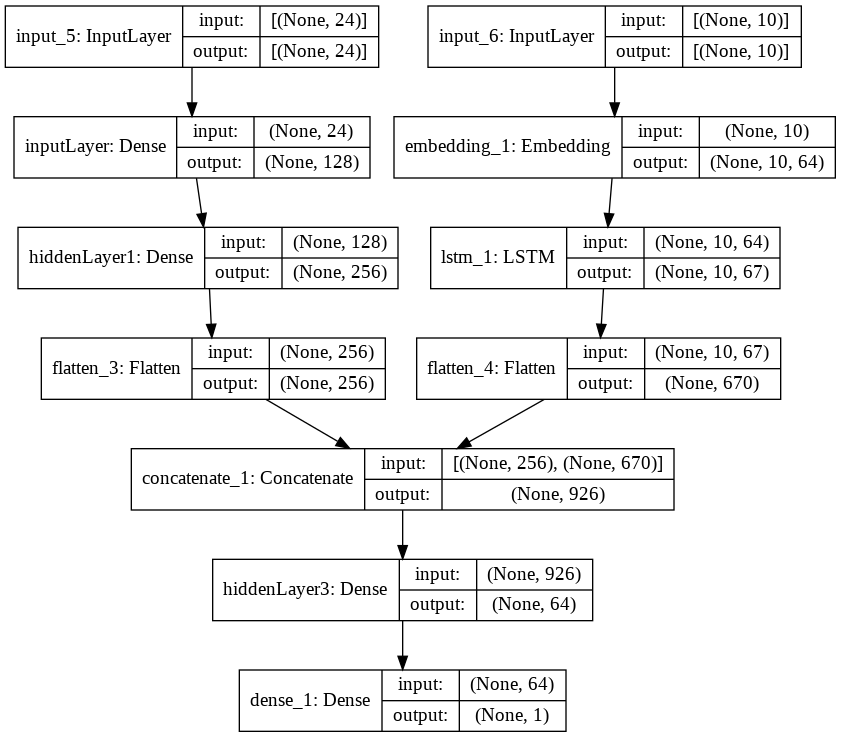

In [41]:
# Создание модели нейронной сети
inputShape = dfX.shape[1]
inputShapePosition = (sequences_position_padded.shape[1])
print(inputShapePosition)

# Создание модели
modelIn = Input(shape=inputShape)
modelInPosition = Input(shape=inputShapePosition)
# Сеть для табличных параметров
inputLayer = Dense(128, name='inputLayer', activation='relu')(modelIn)
hiddenLayer1 = Dense(256, name='hiddenLayer1', activation='tanh')(inputLayer)
hiddenLayer2 = Dense(512, name='hiddenLayer2', activation='relu')(hiddenLayer1)
flattenLayer0 = Flatten()(hiddenLayer1)
# Сеть для токенизированного position
positionEmbedding = Embedding(num_words, 64)(modelInPosition)
positionLSTM = LSTM(67, dropout = 0.1,  return_sequences=True)(positionEmbedding)
flattenLayer1 = Flatten()(positionLSTM)
# Слияние всех потоков в один
concatLayer = concatenate([flattenLayer0,flattenLayer1])
dropoutLayer = Dropout(0.2)(concatLayer)
hiddenLayer3 = Dense(64, name='hiddenLayer3', activation='relu')(concatLayer)
modelOut = Dense(1)(hiddenLayer3)
model = Model([modelIn, modelInPosition],[modelOut])

loss = 'mae'
optimiser=optimizers.Adam(lr=0.0001)
metrics1 = 'mae'
metrics2 = 'mse'
model.compile(optimizer=optimiser, 
              loss=loss, 
              metrics=[metrics1, metrics2, rmsle_metric])
model.summary()
plot_model(model, to_file=ROOT_PATH + 'model_struct.png', expand_nested=True, 
           show_shapes=True, show_layer_names=True)

In [42]:
# Обучение модели
callbacks = [ModelCheckpoint(ROOT_PATH+"best_result_checkpoint",
                             monitor='val_loss', save_best_only=True,
                             verbose=0)]
history = model.fit([xTrain, xTrainPosition],
                    [yTrain], 
                    validation_data=([xTest, xTestPosition], [yTest]),
                    epochs=5,
                    batch_size=16,
                    callbacks=callbacks,
                    shuffle=True)

Epoch 1/5
16061/16061 [==============================] - 239s 14ms/step - loss: 0.0128 - mae: 0.0128 - mse: 3.0481e-04 - rmsle_metric: 0.0042 - val_loss: 0.0125 - val_mae: 0.0125 - val_mse: 2.9716e-04 - val_rmsle_metric: 0.0027


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/PandemicDataHack/best_result_checkpoint/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/PandemicDataHack/best_result_checkpoint/assets


Epoch 2/5
16061/16061 [==============================] - 228s 14ms/step - loss: 0.0111 - mae: 0.0111 - mse: 2.2553e-04 - rmsle_metric: 0.0042 - val_loss: 0.0110 - val_mae: 0.0110 - val_mse: 2.4452e-04 - val_rmsle_metric: 0.0028


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/PandemicDataHack/best_result_checkpoint/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/PandemicDataHack/best_result_checkpoint/assets


Epoch 3/5
16061/16061 [==============================] - 232s 14ms/step - loss: 0.0107 - mae: 0.0107 - mse: 2.1388e-04 - rmsle_metric: 0.0042 - val_loss: 0.0132 - val_mae: 0.0132 - val_mse: 2.6603e-04 - val_rmsle_metric: 0.0039
Epoch 4/5
16061/16061 [==============================] - 233s 15ms/step - loss: 0.0105 - mae: 0.0105 - mse: 2.1034e-04 - rmsle_metric: 0.0043 - val_loss: 0.0122 - val_mae: 0.0122 - val_mse: 2.4113e-04 - val_rmsle_metric: 0.0037
Epoch 5/5
16061/16061 [==============================] - 233s 15ms/step - loss: 0.0104 - mae: 0.0104 - mse: 2.0685e-04 - rmsle_metric: 0.0043 - val_loss: 0.0146 - val_mae: 0.0146 - val_mse: 3.1774e-04 - val_rmsle_metric: 0.0042


[0.011831380426883698, 0.010946664027869701, 0.010680767707526684, 0.01051910687237978, 0.010385972447693348]


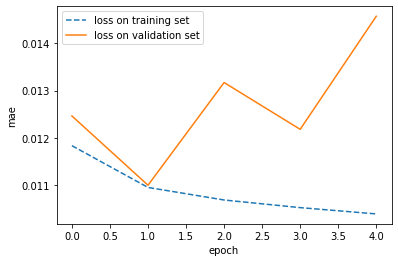

In [43]:
print(history.history['loss'])
plt.plot(history.history['mae'],'--', label='loss on training set')
plt.plot(history.history['val_mae'], label='loss on validation set')
plt.xlabel('epoch')
plt.ylabel('mae')
plt.legend()
plt.savefig(ROOT_PATH+"loss.png")
plt.show()

In [46]:
# Загрузка лучшей модели
model=models.load_model(ROOT_PATH + 'best_result_checkpoint', custom_objects={'rmsle_metric': rmsle_metric})

# Построение прогноза
df = pd.read_csv(ROOT_PATH + 'test.csv', sep=';')

# Для проверки
#df = pd.read_csv(ROOT_PATH + 'train.csv', sep=';')
#df = df[(df['id'] > 1000) & (df['id'] < 1050)].reset_index(drop=True)
#dfZ = df[['id', 'salary']]
#df.drop(['salary'], axis='columns', inplace=True)
#print(dfZ.head(20))


df = clean_and_fill_data(df)
df = convert_for_neural_network(df)
dfPosition = df['position']

# Norm
df['age'] = (df['age'] - ageMin) / (ageMax - ageMin)
df['experience'] = (df['experience'] - experienceMin) / (experienceMax -
                                                         experienceMin)
df['salary_desired'] = df['salary_desired'] / salaryMax

dfId = df['id']
df.drop(['id', 'position'], axis='columns', inplace=True)

sequences_position = tokenizer_position.texts_to_sequences(dfPosition)
max_position_len=10
sequences_position_padded = pad_sequences(sequences_position, maxlen=max_position_len)

yPred = model.predict([df, sequences_position_padded])

#dfId = pd.concat([dfId, yPred], axis=1)
#type(yPred)
#print(yPred * salaryMax, yTry * salaryMax)
#print(int(yPred[0] * salaryMax))
#print(yTry)
#print(yPred)
# print(yPred[:,0])

#plt.plot(dfY['openETF'], label='Исходные значения ряда')
#plt.plot(yPred[:,0], label='Вычисленые значения')
#plt.xlabel('Ряд')
#plt.ylabel('Величина')
#plt.legend()
#plt.savefig(FOLDER+"row.png")
#plt.show()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [47]:
# Сохранение результата
dfY = pd.DataFrame(yPred, columns=['salary'])
dfId = pd.concat([dfId, dfY], axis=1)
dfId['salary'] = dfId['salary'] * salaryMax
dfId['salary'] = dfId['salary'].astype('int64')
dfId.sort_values(by='id', ascending=True)
print(dfId.head(20))
dfId.to_csv(ROOT_PATH + 'result.csv', index=False)
dfId.drop(['salary'], axis='columns', inplace=True)

        id  salary
0        2   19242
1    24653   62719
2    44954   24059
3    73770   37155
4   139274   42874
5   143833   47971
6   153120   34115
7   200455   24972
8   214615   43074
9   218890   36303
10  272491   34531
11  358350   25791
12  369367   57350
13   10953   53561
14   19615   37702
15   21782   26643
16   25444   49917
17   27613   40981
18   30995   24322
19   34659   33462


In [ ]:
# Сохранение модели
model_json = model.to_json()
json_file = open(FOLDER+"my_model" + ".json", "w")
# Сохранение структуры модели
json_file.write(model_json)
json_file.close()
# Сохранение весов
model.save_weights(FOLDER+"my_model"+".h5")
print("Модель сохранена")

In [ ]:
# Загрузка модели
model_json=FOLDER+"my_model.json"
model_h5=FOLDER+"my_model.h5"

# Загрузка структуры модели
json_file = open(model_json, "r")
loaded_model_json = json_file.read()
json_file.close()
model2 = models.model_from_json(loaded_model_json)

# Загрузка весов
model2.load_weights(model_h5)
print("Модель загружена")
# Сборка модели
model = Model(model2.input, model2.layers[-1].output)
model.trainable = True
# После загрузки модели необходимо снова выбрать функцию потерь, оптимизаторы,
# метрики и заново скомпилировать модель для дальнейшей работы.

In [ ]:
#create filters
to_exclude = '".,:!?#$%&()*+-/<=>@[\\]^_`{|}~\t\n'#excluded symbols
to_tokenize = '.,:!?"'#processed symbols

#process data
iterations=len(df.head(100).index)
display(df.head(5))
for i in range(iterations):
    df.iloc[i]['position']=re.sub(to_tokenize, ' ', df.iloc[i]['position'])

    if i%10000==0:
        print(i)
display(df.head(5))

,id,position,region,industry,locality,locality_name,education_type,drive_licences,citizenship,schedule,employement_type,age,gender,experience,salary_desired,relocation_ready,travel_ready,retraining_ready,is_worldskills_participant,has_qualifications,completeness_rate,creation_date,modification_date,publish_date,salary,region_fe,industry_fe,education_type_fe,citizenship_fe,employement_type_fe
0,0,Специалист,Тульская область,"Государственная служба, некоммерческие организ...",7100000100000,Тула,Незаконченное высшее,[B],Российская Федерация,Полный рабочий день,Полная занятость,21.0,1,3,35000,0,0,1,NaN,0,64.0,2020-05-07,2020-05-08,2020-05-07,37500,0.016861,0.072815,0.040619,0.996094,0.938477
1,1,Лаборант,Алтайский край,"Государственная служба, некоммерческие организ...",2200000100000,Барнаул,Высшее,[B],Российская Федерация,Полный рабочий день,Полная занятость,26.0,0,4,15000,0,1,1,NaN,0,88.0,2020-10-21,2020-10-27,2020-10-27,14000,0.011253,0.072815,0.442139,0.996094,0.938477
2,3,"Специалист, администратор, бухгалтер, экономист",Ульяновская область,"Административная работа, секретариат, АХО",7300000200000,Димитровград,Высшее,[B],Российская Федерация,Полный рабочий день,Полная занятость,36.0,0,12,20000,0,0,1,NaN,0,78.0,2019-04-25,2020-02-04,2020-02-04,24600,0.007740,0.106750,0.442139,0.996094,0.938477
3,4,Специалист,Свердловская область,"Государственная служба, некоммерческие организ...",6600002300000,Нижний Тагил,Высшее,[B],Российская Федерация,Полный рабочий день,Полная занятость,34.0,0,9,30000,0,0,0,NaN,0,91.0,2020-09-19,2020-09-20,2020-09-19,16075,0.031860,0.072815,0.442139,0.996094,0.938477
4,5,Инструктор по плаванию,Иркутская область,"Здравоохранение, спорт, красота, социальное об...",3800000400000,Ангарск,NaN,NaN,Российская Федерация,Полный рабочий день,Полная занятость,25.0,1,1,40000,0,0,0,NaN,0,58.0,2020-04-20,2020-09-09,2020-04-21,22080,0.020447,0.039215,NaN,0.996094,0.938477


0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,id,position,region,industry,locality,locality_name,education_type,drive_licences,citizenship,schedule,employement_type,age,gender,experience,salary_desired,relocation_ready,travel_ready,retraining_ready,is_worldskills_participant,has_qualifications,completeness_rate,creation_date,modification_date,publish_date,salary,region_fe,industry_fe,education_type_fe,citizenship_fe,employement_type_fe
0,0,Специалист,Тульская область,"Государственная служба, некоммерческие организ...",7100000100000,Тула,Незаконченное высшее,[B],Российская Федерация,Полный рабочий день,Полная занятость,21.0,1,3,35000,0,0,1,NaN,0,64.0,2020-05-07,2020-05-08,2020-05-07,37500,0.016861,0.072815,0.040619,0.996094,0.938477
1,1,Лаборант,Алтайский край,"Государственная служба, некоммерческие организ...",2200000100000,Барнаул,Высшее,[B],Российская Федерация,Полный рабочий день,Полная занятость,26.0,0,4,15000,0,1,1,NaN,0,88.0,2020-10-21,2020-10-27,2020-10-27,14000,0.011253,0.072815,0.442139,0.996094,0.938477
2,3,"Специалист, администратор, бухгалтер, экономист",Ульяновская область,"Административная работа, секретариат, АХО",7300000200000,Димитровград,Высшее,[B],Российская Федерация,Полный рабочий день,Полная занятость,36.0,0,12,20000,0,0,1,NaN,0,78.0,2019-04-25,2020-02-04,2020-02-04,24600,0.007740,0.106750,0.442139,0.996094,0.938477
3,4,Специалист,Свердловская область,"Государственная служба, некоммерческие организ...",6600002300000,Нижний Тагил,Высшее,[B],Российская Федерация,Полный рабочий день,Полная занятость,34.0,0,9,30000,0,0,0,NaN,0,91.0,2020-09-19,2020-09-20,2020-09-19,16075,0.031860,0.072815,0.442139,0.996094,0.938477
4,5,Инструктор по плаванию,Иркутская область,"Здравоохранение, спорт, красота, социальное об...",3800000400000,Ангарск,NaN,NaN,Российская Федерация,Полный рабочий день,Полная занятость,25.0,1,1,40000,0,0,0,NaN,0,58.0,2020-04-20,2020-09-09,2020-04-21,22080,0.020447,0.039215,NaN,0.996094,0.938477


In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/PandemicDataHack/employements.csv', sep=';')
df.info()
print(df.columns)
print(df['responsibilities'].head(20))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343328 entries, 0 to 343327
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                343328 non-null  int64 
 1   position          332710 non-null  object
 2   employer          340563 non-null  object
 3   achievements      54455 non-null   object
 4   responsibilities  340242 non-null  object
 5   start_date        341220 non-null  object
 6   finish_date       294459 non-null  object
dtypes: int64(1), object(6)
memory usage: 18.3+ MB
Index(['id', 'position', 'employer', 'achievements', 'responsibilities',
       'start_date', 'finish_date'],
      dtype='object')
0     <p>Консультирование клиентов по телефону. Прод...
1     <p><strong>✑</strong><strong>Фриланс</strong><...
2     <p>Прохождение производственной практики (30.0...
3       <p>Работа с клиентами, оформление договоров</p>
4     <p>Обслуживание физических лиц, активное привл...
5   